In [8]:
# %pip install pycaret[full]
# %pip install ctgan

In [556]:
from pycaret.classification import *
import matplotlib.pyplot as plt
from ctgan import CTGAN
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, RocCurveDisplay, PrecisionRecallDisplay, auc, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
from imblearn.metrics import classification_report_imbalanced
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
import torch.optim as optim
import numpy as np

In [385]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [386]:
df = pd.read_csv("./creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [387]:
# Check if dataset has any NaN
df.isnull().any().any()

False

In [388]:
# Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
df['Time'].describe()

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64

In [389]:
2 * 24 * 60 * 60 # 2 days of data in seconds

172800

In [390]:
# Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [391]:
# Test size of 8 hours, remaining for training
test_hours = 8
train_hours = 48 - test_hours
train_delta = train_hours * 60 * 60 # Convert to seconds
train_df = df[(df['Time'] >= 0) & (df['Time'] < train_delta)]
test_df = df[df['Time'] >= train_delta]

In [392]:
train_df['Class'].value_counts()

0    224450
1       415
Name: Class, dtype: int64

In [393]:
test_df['Class'].value_counts()

0    59865
1       77
Name: Class, dtype: int64

# Common Utilities

In [568]:
def common_metrics(y_true, y_pred, y_prob):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
    RocCurveDisplay.from_predictions(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    #
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true, y_prob, ax=ax)
    # P / (P + N)
    ap_frauds = (len(y_true[y_true == 1]) / len(y_true))
    plt.axhline(y=ap_frauds, color='r', linestyle='-') 
    plt.show()
    #
    print(classification_report_imbalanced(y_true, y_pred))
    print("AUPRC:", auc(recall, precision))
    print("AP:", average_precision_score(y_true, y_prob))

In [898]:
def common_regression_models(train_df, test_df):
    r = setup(data=train_df, target='Class', session_id=42, train_size=0.80)
    r.add_metric('apc', 'APC', average_precision_score, target='pred_proba')
    best = r.compare_models(sort='AUC')

    pred_df = predict_model(best, data=test_df.copy().drop('Class', axis=1), raw_score=True)
    l = np.argmax(pred_df[['prediction_score_0', 'prediction_score_1']].values, axis=1)
    p = pred_df[['prediction_score_0', 'prediction_score_1']].values.squeeze()
    p_bin = p[:, 1]
    p_bin[l == 0] = 1.0 - p[l == 0][:, 0]
    common_metrics(test_df['Class'].values, l, p_bin)

    return best

# Baseline Models

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(224865, 31)"
4,Transformed data shape,"(224865, 31)"
5,Transformed train set shape,"(179892, 31)"
6,Transformed test set shape,"(44973, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
catboost,CatBoost Classifier,0.9996,0.9770,0.8254,0.9371,0.8757,0.8754,0.8782,0.8578,7.1280
qda,Quadratic Discriminant Analysis,0.9763,0.9677,0.8705,0.0639,0.1191,0.1160,0.2322,0.1657,0.1700
ada,Ada Boost Classifier,0.9992,0.9676,0.7411,0.8113,0.7718,0.7714,0.7736,0.7773,4.3650
nb,Naive Bayes,0.9915,0.9666,0.6867,0.1383,0.2301,0.2277,0.3056,0.1902,0.1960
rf,Random Forest Classifier,0.9995,0.9518,0.7953,0.9395,0.8605,0.8603,0.8637,0.8564,7.3120
et,Extra Trees Classifier,0.9995,0.9515,0.7953,0.9469,0.8631,0.8629,0.8669,0.8600,1.6270
lr,Logistic Regression,0.9991,0.9409,0.6113,0.8510,0.7072,0.7067,0.7186,0.6950,1.3210
lda,Linear Discriminant Analysis,0.9993,0.9095,0.7560,0.8530,0.7993,0.7990,0.8016,0.6932,0.1860
dt,Decision Tree Classifier,0.9991,0.8900,0.7804,0.7515,0.7636,0.7631,0.7643,0.5882,0.9400
gbc,Gradient Boosting Classifier,0.9991,0.7755,0.6454,0.8394,0.7189,0.7185,0.7298,0.5986,22.3340


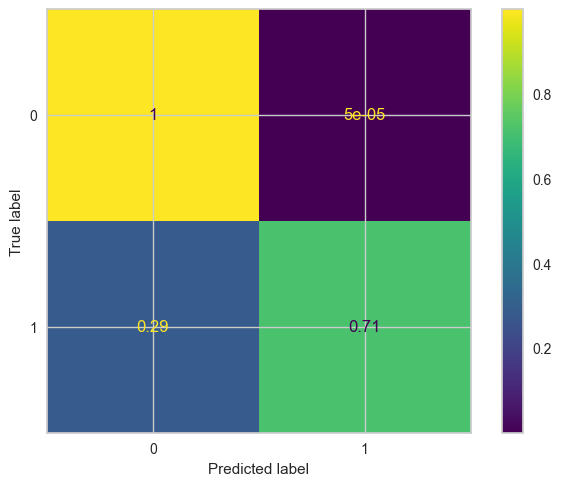

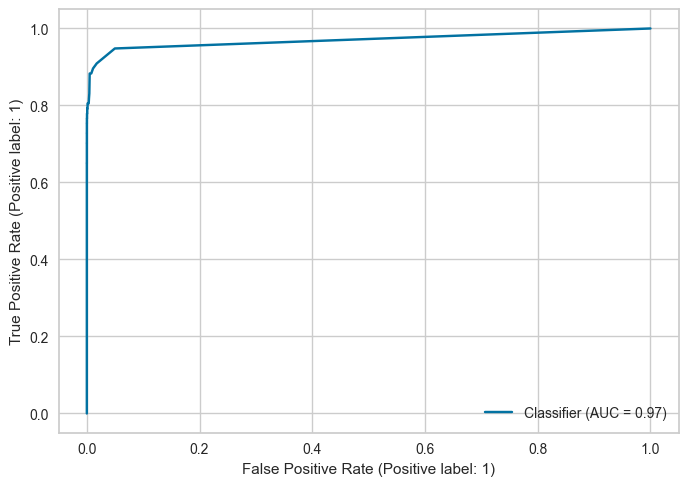

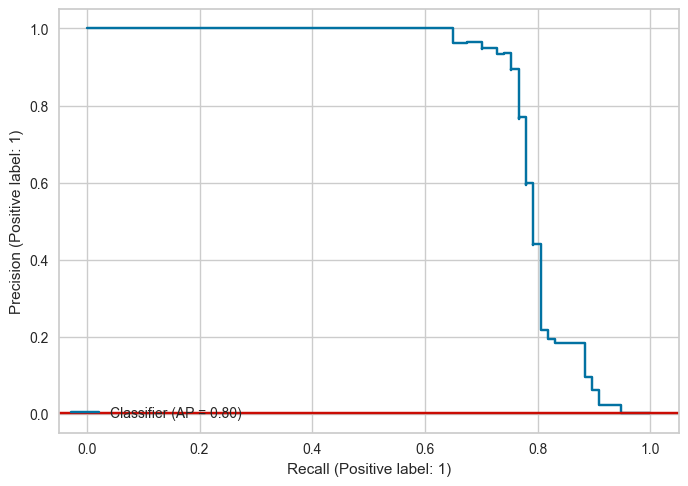

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.71      1.00      0.85      0.73     59865
          1       0.95      0.71      1.00      0.81      0.85      0.69        77

avg / total       1.00      1.00      0.71      1.00      0.85      0.73     59942

AUPRC: 0.803559753773564
AP: 0.8013265248331971


In [899]:
best_baseline = common_regression_models(train_df, test_df)

# CTGAN

## Data Generation

In [869]:
discrete_columns = ['Class']
ctgan = CTGAN(epochs=300, verbose=True)
ctgan.fit(train_df, discrete_columns)

Gen. (-0.53) | Discrim. (-0.10): 100%|██████████| 300/300 [1:04:38<00:00, 12.93s/it]


In [870]:
synthetic_train = ctgan.sample(train_df[train_df['Class'] == 0]['Class'].value_counts()[0])
synthetic_train['Class'].value_counts()

1    125475
0     98975
Name: Class, dtype: int64

In [871]:
gan_train_df = pd.concat([train_df, synthetic_train[synthetic_train['Class'] == 1]], ignore_index=True)
gan_train_df['Class'].value_counts()

0    224450
1    125890
Name: Class, dtype: int64

## Evaluation

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(350340, 31)"
4,Transformed data shape,"(350340, 31)"
5,Transformed train set shape,"(280272, 31)"
6,Transformed test set shape,"(70068, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
catboost,CatBoost Classifier,0.9962,0.9999,0.9907,0.9987,0.9947,0.9917,0.9917,0.9998,11.1610
et,Extra Trees Classifier,0.9846,0.9994,0.9605,0.9964,0.9781,0.9662,0.9666,0.9989,6.8840
rf,Random Forest Classifier,0.9860,0.9990,0.9663,0.9945,0.9802,0.9694,0.9696,0.9984,22.5290
lightgbm,Light Gradient Boosting Machine,0.9849,0.9988,0.9652,0.9925,0.9787,0.9670,0.9672,0.9981,0.8170
gbc,Gradient Boosting Classifier,0.9622,0.9919,0.9117,0.9818,0.9455,0.9166,0.9181,0.9885,38.4170
ada,Ada Boost Classifier,0.9529,0.9863,0.9037,0.9628,0.9323,0.8962,0.8973,0.9820,7.0130
qda,Quadratic Discriminant Analysis,0.9212,0.9715,0.8553,0.9199,0.8864,0.8263,0.8276,0.9444,0.2480
lda,Linear Discriminant Analysis,0.9005,0.9687,0.7388,0.9792,0.8421,0.7716,0.7879,0.9569,0.3140
dt,Decision Tree Classifier,0.9659,0.9621,0.9487,0.9561,0.9524,0.9258,0.9259,0.9255,2.7230
lr,Logistic Regression,0.9272,0.9590,0.8609,0.9313,0.8947,0.8392,0.8408,0.9539,0.4430


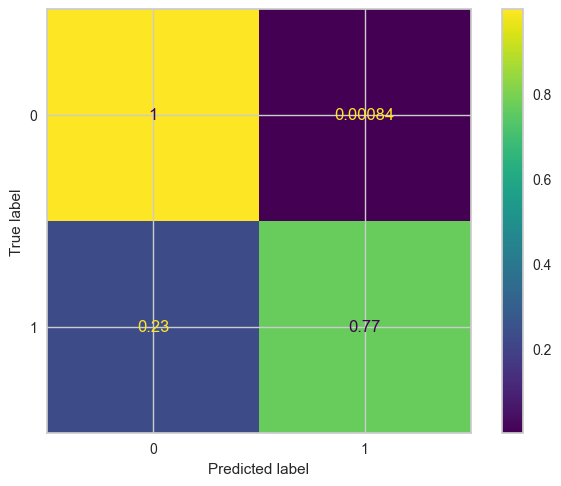

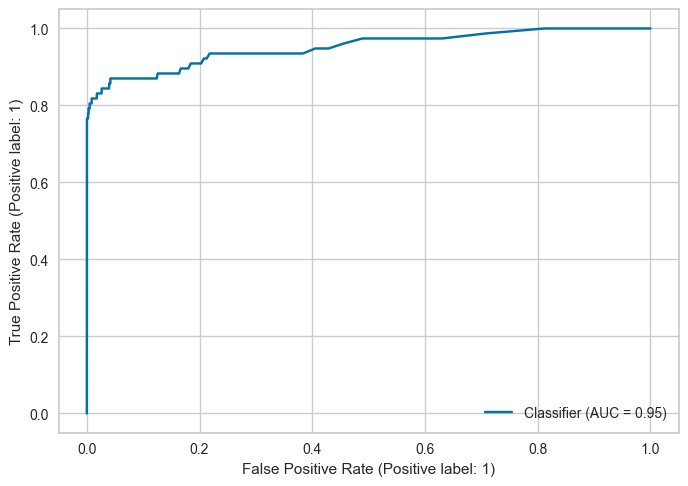

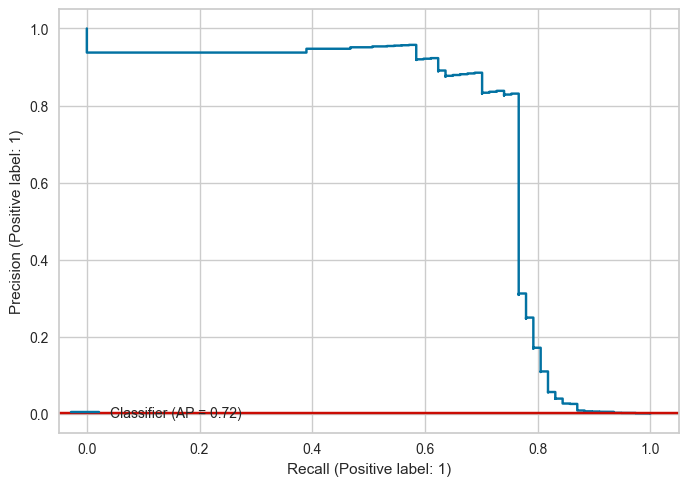

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.77      1.00      0.87      0.78     59865
          1       0.54      0.77      1.00      0.63      0.87      0.75        77

avg / total       1.00      1.00      0.77      1.00      0.87      0.78     59942

AUPRC: 0.7342843553741548
AP: 0.7228863542988991


In [900]:
best_ctgan = common_regression_models(gan_train_df, test_df)

# WGAN

## Data Generation

In [906]:
class FraudDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df[in_df['Class'] == 1].copy()
        x_frauds = self.df.drop(['Class'], axis=1).values
        self.x_frauds = torch.Tensor(x_frauds).to(DEVICE)
        self.features = self.x_frauds.shape[1]

    def __len__(self):
        return len(self.x_frauds)

    def __getitem__(self, idx):
        return self.x_frauds[idx]

In [907]:
class Generator(nn.Module):
    def __init__(self, latent_size, output_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_size),
        )

    def forward(self, x):
        return self.model(x)

In [908]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )

    def forward(self, x):
        return self.model(x)

In [909]:
class WGAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.batch_size = 64
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = FraudDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)

        self.G = Generator(latent_size=latent_size, output_size=self.dataset.features).to(DEVICE)
        self.D = Discriminator(input_size=self.dataset.features).to(DEVICE)
        self.latent_size = latent_size

        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.lr)
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.lr)

    def train(self, epochs=1000):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            epoch_loss_D = 0
            epoch_loss_G = 0
            for i, real_frauds in enumerate(self.dataloader):
                # Train Discriminator
                self.d_optimizer.zero_grad()
                z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_frauds.shape[0], self.latent_size))).to(DEVICE))
                fake_frauds = self.G(z).detach()

                # Adversarial Loss
                loss_D = -torch.mean(self.D(real_frauds)) + torch.mean(self.D(fake_frauds))
                loss_D.backward()
                self.d_optimizer.step()

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                epoch_loss_D += loss_D.item()
                # Train the generator every n_critic iterations
                if i % self.n_critic == 0:
                    # Train Generator
                    self.g_optimizer.zero_grad()
                    gen_frauds = self.G(z)
                    # Adversarial Loss
                    loss_G = -torch.mean(self.D(gen_frauds))
                    loss_G.backward()
                    self.g_optimizer.step()
                    epoch_loss_G += loss_G.item()                

            g_losses.append(epoch_loss_G / i)
            d_losses.append(epoch_loss_D / i)
            print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, epochs, d_losses[-1], g_losses[-1]))

        return pd.DataFrame({
            'Generator Loss': g_losses,
            'Discriminator Loss': d_losses,
        })

    def sample(self, count):
        with torch.no_grad():
            z = torch.Tensor(np.random.normal(0, 1, (count, self.latent_size))).to(DEVICE)
            return self.G(z).cpu().numpy()

In [910]:
wgan = WGAN(train_df)

[Epoch 0/1000] [D loss: -0.001158] [G loss: 0.000559]
[Epoch 1/1000] [D loss: -0.000818] [G loss: 0.000622]
[Epoch 2/1000] [D loss: -0.000720] [G loss: 0.000570]
[Epoch 3/1000] [D loss: -0.000535] [G loss: 0.000489]
[Epoch 4/1000] [D loss: -0.000359] [G loss: 0.000413]
[Epoch 5/1000] [D loss: -0.000329] [G loss: 0.000401]
[Epoch 6/1000] [D loss: -0.000295] [G loss: 0.000393]
[Epoch 7/1000] [D loss: -0.000333] [G loss: 0.000408]
[Epoch 8/1000] [D loss: -0.000379] [G loss: 0.000422]
[Epoch 9/1000] [D loss: -0.000486] [G loss: 0.000467]
[Epoch 10/1000] [D loss: -0.000678] [G loss: 0.000505]
[Epoch 11/1000] [D loss: -0.000863] [G loss: 0.000542]
[Epoch 12/1000] [D loss: -0.001162] [G loss: 0.000589]
[Epoch 13/1000] [D loss: -0.001411] [G loss: 0.000594]
[Epoch 14/1000] [D loss: -0.001733] [G loss: 0.000655]
[Epoch 15/1000] [D loss: -0.002130] [G loss: 0.000716]
[Epoch 16/1000] [D loss: -0.002586] [G loss: 0.000688]
[Epoch 17/1000] [D loss: -0.002844] [G loss: 0.000757]
[Epoch 18/1000] [D l

<AxesSubplot: title={'center': 'WGAN Epoch Losses'}>

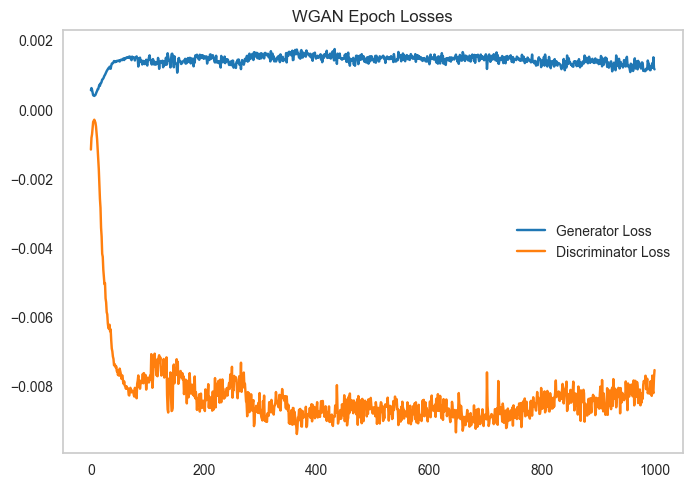

In [911]:
wgan_loss_df = wgan.train(epochs=1000)
wgan_loss_df.plot(title='WGAN Epoch Losses', grid=False, color=['tab:blue', 'tab:orange'])

In [912]:
# Set to equilibrium
wgan_nsamples = train_df[train_df['Class'] == 0]['Class'].value_counts()[0]
wgan_nsamples = wgan_nsamples - train_df[train_df['Class'] == 1]['Class'].value_counts()[1]
# Generate it
samples = wgan.sample(wgan_nsamples)
# Append to train
samples = np.append(samples, np.ones((len(samples), 1)), axis=1)
wgan_train_df = pd.concat([train_df, pd.DataFrame(samples, columns=train_df.columns)], ignore_index=True)
wgan_train_df['Class'].value_counts()

0.0    224450
1.0    224450
Name: Class, dtype: int64

## Evaluation

,Description,Value
0,Session id,42
1,Target,Class
2,Target type,Binary
3,Original data shape,"(448900, 31)"
4,Transformed data shape,"(448900, 31)"
5,Transformed train set shape,"(359120, 31)"
6,Transformed test set shape,"(89780, 31)"
7,Numeric features,30
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,APC,TT (Sec)
catboost,CatBoost Classifier,0.9998,1.0000,0.9996,0.9999,0.9998,0.9995,0.9995,1.0000,10.3440
rf,Random Forest Classifier,0.9997,0.9999,0.9996,0.9999,0.9997,0.9995,0.9995,0.9999,10.0870
ada,Ada Boost Classifier,0.9996,0.9999,0.9995,0.9997,0.9996,0.9993,0.9993,1.0000,7.6100
gbc,Gradient Boosting Classifier,0.9997,0.9999,0.9995,0.9998,0.9997,0.9994,0.9994,0.9999,39.5340
et,Extra Trees Classifier,0.9998,0.9999,0.9996,0.9999,0.9998,0.9995,0.9995,0.9999,4.3460
lightgbm,Light Gradient Boosting Machine,0.9997,0.9999,0.9996,0.9999,0.9997,0.9995,0.9995,1.0000,0.6620
dt,Decision Tree Classifier,0.9995,0.9995,0.9996,0.9995,0.9995,0.9991,0.9991,0.9993,1.3630
knn,K Neighbors Classifier,0.9991,0.9993,0.9982,1.0000,0.9991,0.9982,0.9982,0.9993,9.6760
qda,Quadratic Discriminant Analysis,0.9981,0.9991,0.9963,1.0000,0.9981,0.9962,0.9962,0.9990,0.3710
nb,Naive Bayes,0.9837,0.9990,0.9979,0.9703,0.9839,0.9673,0.9677,0.9993,0.2400


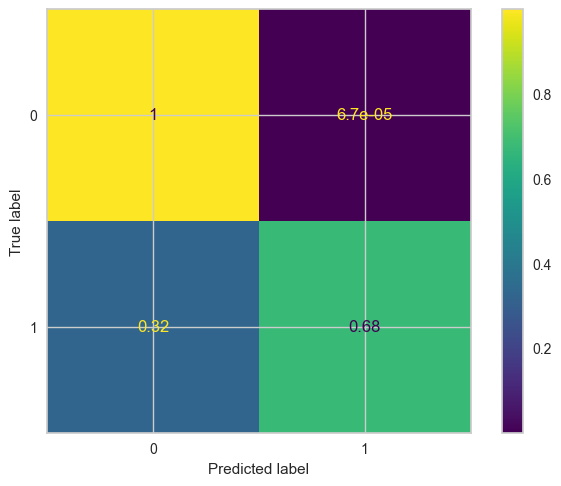

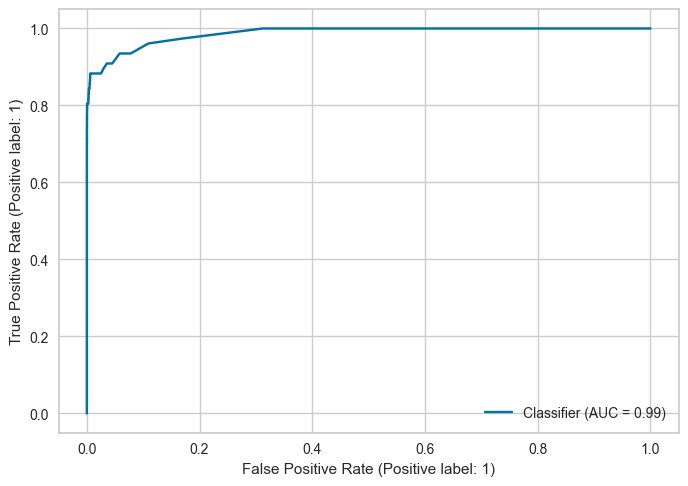

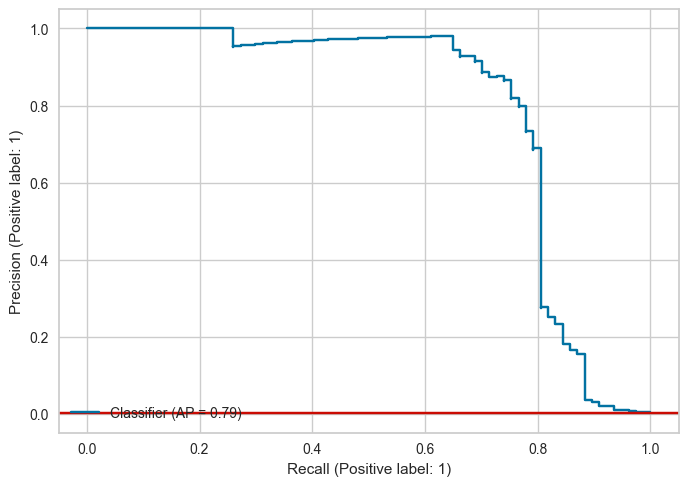

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.68      1.00      0.82      0.70     59865
          1       0.93      0.68      1.00      0.78      0.82      0.65        77

avg / total       1.00      1.00      0.68      1.00      0.82      0.70     59942

AUPRC: 0.7896480396225283
AP: 0.789668600458794


In [913]:
best_wgan = common_regression_models(wgan_train_df, test_df)

# NN Model

In [914]:
class CardDataset(Dataset):
    def __init__(self, in_df):
        self.df = in_df.copy()
        x = self.df.drop(['Class'], axis=1).values
        y = self.df['Class'].values
        self.x_train = torch.Tensor(x).to(DEVICE)
        self.y_train = torch.Tensor(y).to(DEVICE)
        self.features = x.shape[1]

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [915]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [916]:
class FraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 64
        self.dataset = CardDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = Model(input_size=self.dataset.features).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for i, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, epoch_loss / i))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()

    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(DEVICE)
        preds = self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(test_df['Class'].values, labels, preds)

## Evaluation

[Epoch 0/100] loss: 0.052365
[Epoch 1/100] loss: 0.013493
[Epoch 2/100] loss: 0.009666
[Epoch 3/100] loss: 0.006329
[Epoch 4/100] loss: 0.005646
[Epoch 5/100] loss: 0.004896
[Epoch 6/100] loss: 0.005075
[Epoch 7/100] loss: 0.005176
[Epoch 8/100] loss: 0.005139
[Epoch 9/100] loss: 0.004890
[Epoch 10/100] loss: 0.004912
[Epoch 11/100] loss: 0.005066
[Epoch 12/100] loss: 0.005081
[Epoch 13/100] loss: 0.005001
[Epoch 14/100] loss: 0.005093
[Epoch 15/100] loss: 0.004760
[Epoch 16/100] loss: 0.004456
[Epoch 17/100] loss: 0.003972
[Epoch 18/100] loss: 0.004626
[Epoch 19/100] loss: 0.004938
[Epoch 20/100] loss: 0.004841
[Epoch 21/100] loss: 0.004451
[Epoch 22/100] loss: 0.004742
[Epoch 23/100] loss: 0.004721
[Epoch 24/100] loss: 0.004970
[Epoch 25/100] loss: 0.004703
[Epoch 26/100] loss: 0.004356
[Epoch 27/100] loss: 0.004003
[Epoch 28/100] loss: 0.004292
[Epoch 29/100] loss: 0.003716
[Epoch 30/100] loss: 0.003587
[Epoch 31/100] loss: 0.004119
[Epoch 32/100] loss: 0.004294
[Epoch 33/100] loss:

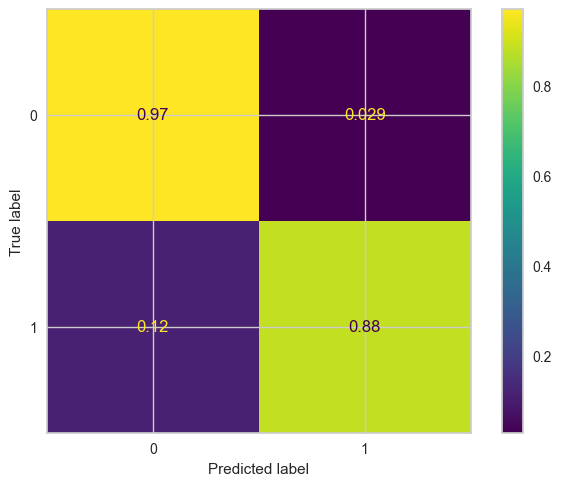

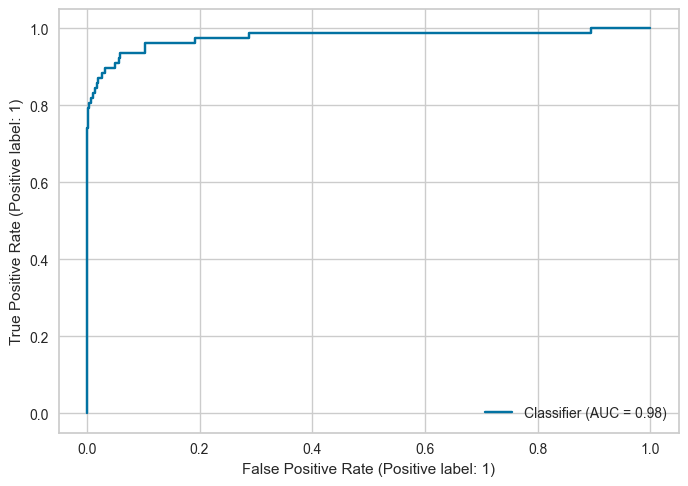

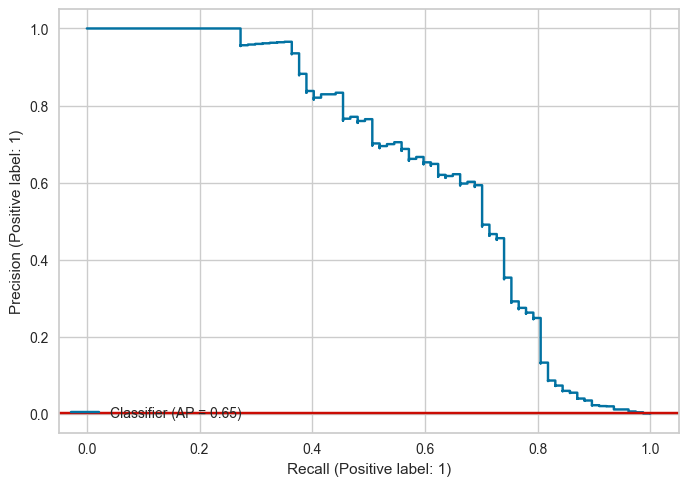

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.88      0.99      0.93      0.87     59865
          1       0.04      0.88      0.97      0.07      0.93      0.85        77

avg / total       1.00      0.97      0.88      0.98      0.93      0.87     59942

AUPRC: 0.6476635612894284
AP: 0.6488259638693963


In [917]:
fb_model = FraudModel(train_df)
fb_model.train()
fb_model.evaluate(test_df)

[Epoch 0/100] loss: 0.269228
[Epoch 1/100] loss: 0.207644
[Epoch 2/100] loss: 0.199138
[Epoch 3/100] loss: 0.194605
[Epoch 4/100] loss: 0.190411
[Epoch 5/100] loss: 0.186831
[Epoch 6/100] loss: 0.182825
[Epoch 7/100] loss: 0.177887
[Epoch 8/100] loss: 0.171979
[Epoch 9/100] loss: 0.169798
[Epoch 10/100] loss: 0.165362
[Epoch 11/100] loss: 0.160032
[Epoch 12/100] loss: 0.156425
[Epoch 13/100] loss: 0.151812
[Epoch 14/100] loss: 0.147032
[Epoch 15/100] loss: 0.145680
[Epoch 16/100] loss: 0.139196
[Epoch 17/100] loss: 0.131996
[Epoch 18/100] loss: 0.125421
[Epoch 19/100] loss: 0.121652
[Epoch 20/100] loss: 0.115156
[Epoch 21/100] loss: 0.109748
[Epoch 22/100] loss: 0.105297
[Epoch 23/100] loss: 0.098134
[Epoch 24/100] loss: 0.094473
[Epoch 25/100] loss: 0.092670
[Epoch 26/100] loss: 0.089475
[Epoch 27/100] loss: 0.088537
[Epoch 28/100] loss: 0.085726
[Epoch 29/100] loss: 0.107726
[Epoch 30/100] loss: 0.102958
[Epoch 31/100] loss: 0.096027
[Epoch 32/100] loss: 0.093005
[Epoch 33/100] loss:

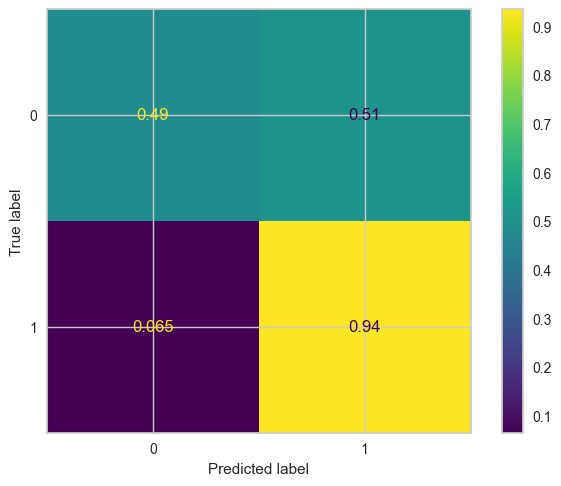

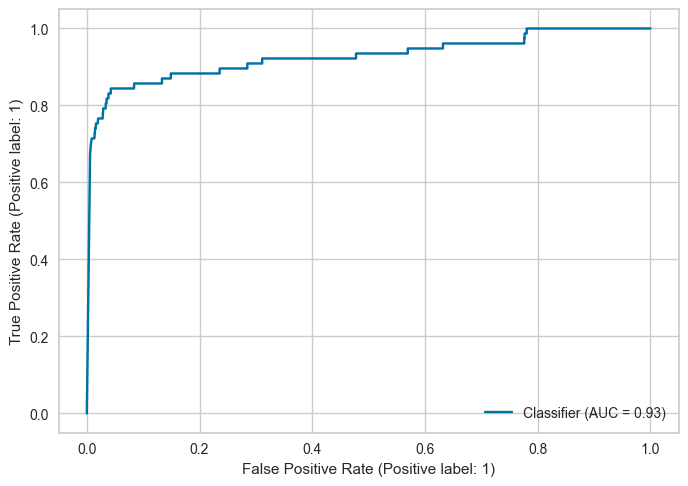

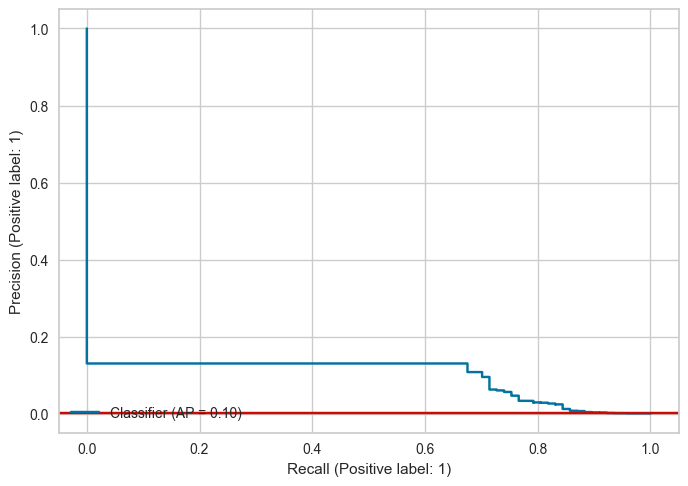

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.49      0.94      0.66      0.68      0.44     59865
          1       0.00      0.94      0.49      0.00      0.68      0.48        77

avg / total       1.00      0.49      0.93      0.65      0.68      0.44     59942

AUPRC: 0.3923148458997112
AP: 0.09851482112660578


In [918]:
fs_model = FraudModel(gan_train_df)
fs_model.train()
fs_model.evaluate(test_df)

[Epoch 0/100] loss: 0.036330
[Epoch 1/100] loss: 0.037757
[Epoch 2/100] loss: 0.036745
[Epoch 3/100] loss: 0.032998
[Epoch 4/100] loss: 0.036587
[Epoch 5/100] loss: 0.033966
[Epoch 6/100] loss: 0.036623
[Epoch 7/100] loss: 0.031457
[Epoch 8/100] loss: 0.028620
[Epoch 9/100] loss: 0.029434
[Epoch 10/100] loss: 0.024129
[Epoch 11/100] loss: 0.022036
[Epoch 12/100] loss: 0.036018
[Epoch 13/100] loss: 0.019264
[Epoch 14/100] loss: 0.019893
[Epoch 15/100] loss: 0.021151
[Epoch 16/100] loss: 0.018971
[Epoch 17/100] loss: 0.013282
[Epoch 18/100] loss: 0.013378
[Epoch 19/100] loss: 0.012950
[Epoch 20/100] loss: 0.012323
[Epoch 21/100] loss: 0.012003
[Epoch 22/100] loss: 0.012207
[Epoch 23/100] loss: 0.012203
[Epoch 24/100] loss: 0.010271
[Epoch 25/100] loss: 0.011579
[Epoch 26/100] loss: 0.010839
[Epoch 27/100] loss: 0.009891
[Epoch 28/100] loss: 0.011155
[Epoch 29/100] loss: 0.010845
[Epoch 30/100] loss: 0.011855
[Epoch 31/100] loss: 0.009152
[Epoch 32/100] loss: 0.009094
[Epoch 33/100] loss:

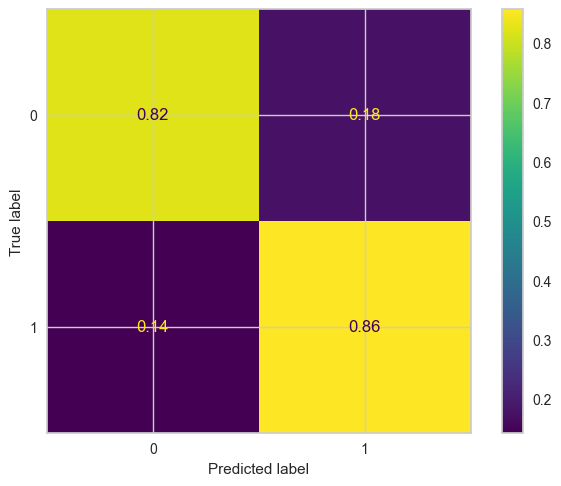

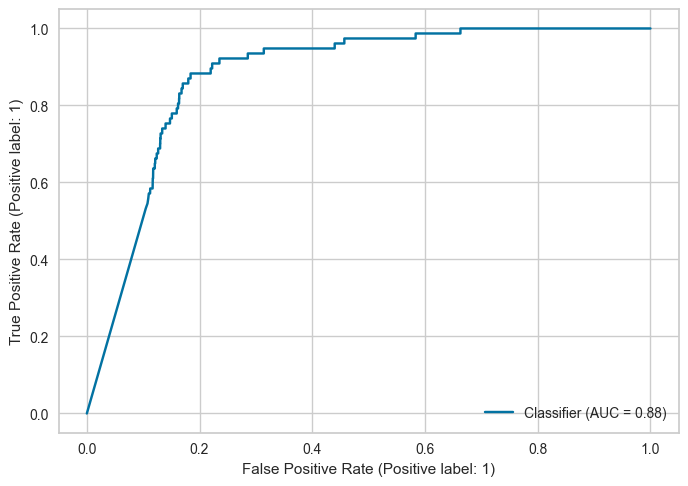

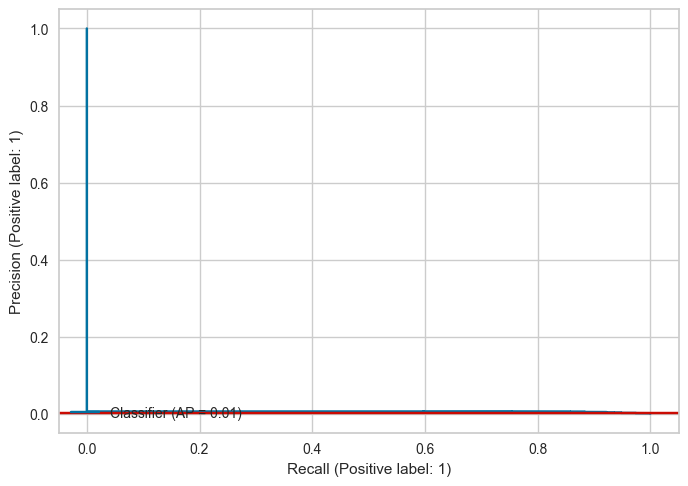

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.82      0.86      0.90      0.84      0.70     59865
          1       0.01      0.86      0.82      0.01      0.84      0.71        77

avg / total       1.00      0.82      0.86      0.90      0.84      0.70     59942

AUPRC: 0.2707112290401833
AP: 0.006232656557731782


In [919]:
fw_model = FraudModel(wgan_train_df)
fw_model.train()
fw_model.evaluate(test_df)

# Anomaly Detection WGAN

In [920]:
class BinaryDiscriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return torch.flatten(self.model(x))

In [ ]:
class AnomalyWGAN:
    def __init__(self, train_df, latent_size=128):
        self.lr = 0.00005
        self.a_lr = 0.0002
        self.batch_size = 128
        self.n_critic = 5
        self.clip_value = 0.01

        self.dataset = CardDataset(train_df)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True, drop_last=True)

        self.G = Generator(latent_size=latent_size, output_size=self.dataset.features).to(DEVICE)
        self.D = Discriminator(input_size=self.dataset.features).to(DEVICE)
        self.D_2 = BinaryDiscriminator(input_size=self.dataset.features).to(DEVICE)
        self.latent_size = latent_size

        self.g_optimizer = optim.RMSprop(self.G.parameters(), lr=self.lr)
        self.d_optimizer = optim.RMSprop(self.D.parameters(), lr=self.lr)
        self.d_2_optimizer = optim.Adam(self.D_2.parameters(), lr=self.a_lr)
        self.criterion = nn.BCELoss()

    def train(self, epochs=1000):
        g_losses = []
        d_losses = []
        d_2_losses = []
        for epoch in range(epochs):
            for i, (real_ops, real_labels) in enumerate(self.dataloader):
                # Label smoothing
                real_label = torch.ones(real_ops.shape[0]).to(DEVICE) * 0.90 * (1.00 - real_labels)
                fake_label = torch.ones(real_ops.shape[0]).to(DEVICE) * 0.10

                # Train Discriminator
                self.d_optimizer.zero_grad()
                z = torch.autograd.Variable(torch.Tensor(np.random.normal(0, 1, (real_ops.shape[0], self.latent_size))).to(DEVICE))
                fake_ops = self.G(z).detach()

                # Adversarial Loss
                loss_D = -torch.mean(self.D(real_ops)) + torch.mean(self.D(fake_ops))
                loss_D.backward()
                self.d_optimizer.step()

                # Clip weights of discriminator
                for p in self.D.parameters():
                    p.data.clamp_(-self.clip_value, self.clip_value)

                # Train Binary Discriminator
                self.d_2_optimizer.zero_grad()
                loss_D_2 = self.criterion(self.D_2(real_ops), real_label) + self.criterion(self.D_2(fake_ops), fake_label)
                loss_D_2.backward()
                self.d_2_optimizer.step()

                # Train the generator every n_critic iterations
                if i % self.n_critic == 0:
                    # Train Generator
                    self.g_optimizer.zero_grad()
                    gen_ops = self.G(z)

                    # Adversarial Loss
                    loss_G = -torch.mean(self.D(gen_ops))
                    loss_G.backward()
                    self.g_optimizer.step()

            print("[Epoch %d/%d] [D loss: %f] [D_2 loss: %f] [G loss: %f]" % (epoch, epochs, loss_D.item(), loss_D_2.item(), loss_G.item()))
            g_losses.append(loss_G.item())
            d_losses.append(loss_D.item())
            d_2_losses.append(loss_D_2.item())

        return pd.DataFrame({
            'Generator Loss': g_losses,
            'Discriminator Loss': d_losses,
            'Binary Discriminator Loss': d_2_losses,
        })

    def predict(self, x):
        with torch.no_grad():
            preds = self.D_2(x)
            return preds.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input = torch.Tensor(test_df.drop(['Class'], axis=1).values).to(DEVICE)
        preds = 1.0 - self.predict(input)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(test_df['Class'].values, labels, preds)

In [ ]:
awgan = AnomalyWGAN(train_df)

[Epoch 0/100] [D loss: -0.007804] [D_2 loss: 0.326467] [G loss: 0.011625]
[Epoch 1/100] [D loss: -0.008100] [D_2 loss: 0.333265] [G loss: 0.011862]
[Epoch 2/100] [D loss: -0.008399] [D_2 loss: 0.333821] [G loss: 0.012003]
[Epoch 3/100] [D loss: -0.008712] [D_2 loss: 0.332130] [G loss: 0.012166]
[Epoch 4/100] [D loss: -0.008808] [D_2 loss: 0.325458] [G loss: 0.012061]
[Epoch 5/100] [D loss: -0.008858] [D_2 loss: 0.331450] [G loss: 0.012187]
[Epoch 6/100] [D loss: -0.008887] [D_2 loss: 0.326549] [G loss: 0.012251]
[Epoch 7/100] [D loss: -0.008909] [D_2 loss: 0.325641] [G loss: 0.012324]
[Epoch 8/100] [D loss: -0.009061] [D_2 loss: 0.328347] [G loss: 0.012395]
[Epoch 9/100] [D loss: -0.009048] [D_2 loss: 0.326026] [G loss: 0.012380]
[Epoch 10/100] [D loss: -0.008971] [D_2 loss: 0.325578] [G loss: 0.012334]
[Epoch 11/100] [D loss: -0.008954] [D_2 loss: 0.325527] [G loss: 0.012487]
[Epoch 12/100] [D loss: -0.008971] [D_2 loss: 0.325578] [G loss: 0.012327]
[Epoch 13/100] [D loss: -0.009225] 

<AxesSubplot: title={'center': 'Epoch Losses'}>

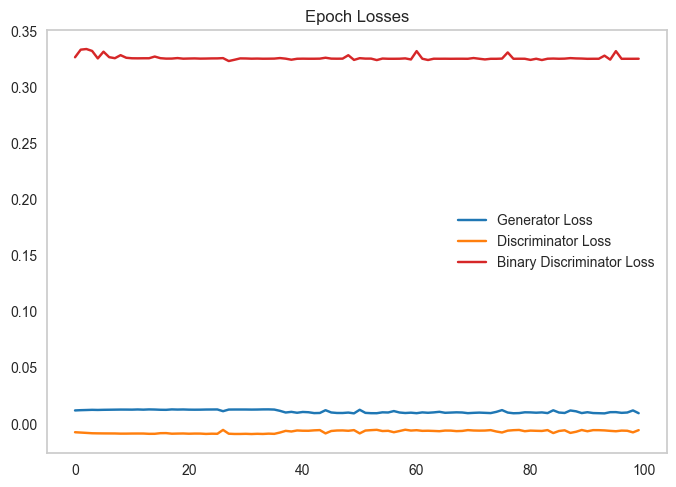

In [ ]:
awgan_loss_df = awgan.train(epochs=100)
awgan_loss_df.plot(title='Epoch Losses', grid=False, color=['tab:blue', 'tab:orange', 'tab:red'])

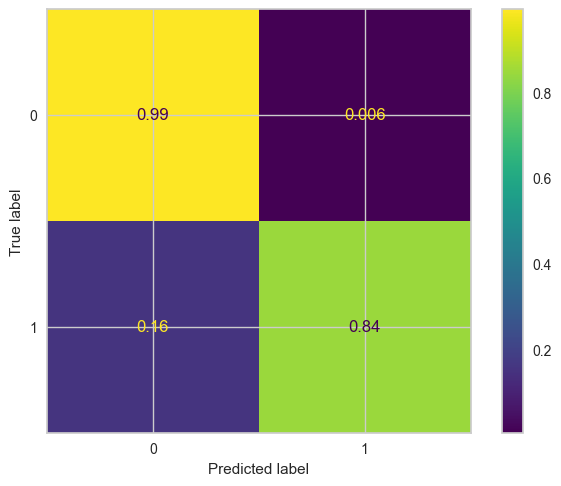

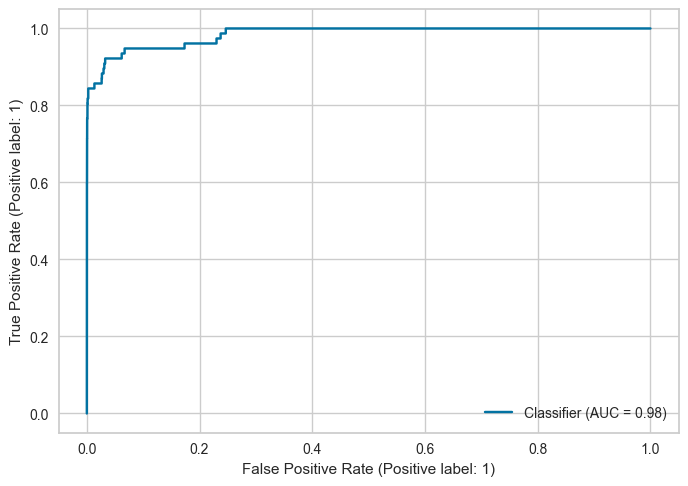

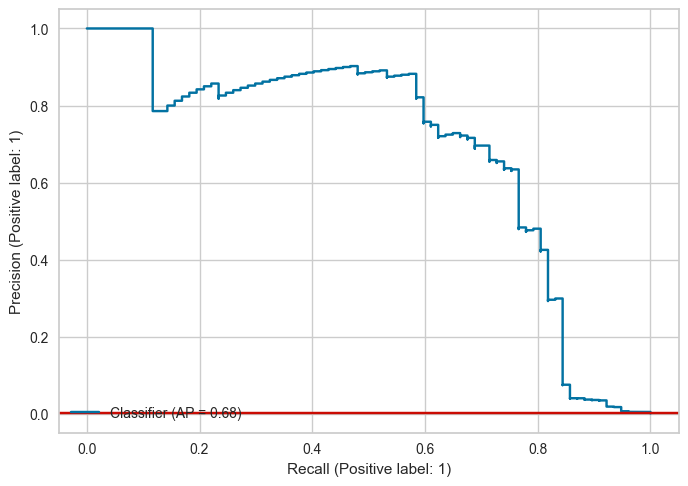

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.84      1.00      0.92      0.85     59865
          1       0.15      0.84      0.99      0.26      0.92      0.83        77

avg / total       1.00      0.99      0.84      1.00      0.92      0.85     59942

AUPRC: 0.684371596619425
AP: 0.6846170218848826


In [ ]:
awgan.evaluate(test_df)

# LSTM-Based Detection

In [925]:
def create_time_dataset(in_df, seq_size=10):
    X, y = [], []
    for i in range(len(in_df) - seq_size):
        slice = in_df[i:i+seq_size]
        X.append(slice.drop(['Class', 'Time'], axis=1).values)
        y.append(slice['Class'].values[-1])
    return torch.Tensor(X).to(DEVICE), torch.Tensor(y).to(DEVICE)

In [932]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_size = 256
        self.lstm = nn.LSTM(input_size,
                            hidden_size=self.hidden_size,
                            num_layers=5,
                            bidirectional=True,
                            batch_first=True)
        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x, hx = self.lstm(x)
        out = torch.cat((hx[0][-2, :, :], hx[0][-1, :, :]), dim=1)
        return torch.flatten(self.linear(out))

In [933]:
class LSTMFraudModel:
    def __init__(self, train_df):
        self.lr = 0.0001
        self.batch_size = 128
        X_train, y_train = create_time_dataset(train_df)
        self.dataset = TensorDataset(X_train, y_train)
        self.dataloader = DataLoader(self.dataset, self.batch_size, shuffle=True)
        self.model = LSTMModel(input_size=X_train.shape[2]).to(DEVICE)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss = nn.BCELoss()

    def train(self, epochs=100):
        for epoch in range(epochs):
            epoch_loss = 0
            for _, (x, y) in enumerate(self.dataloader):
                self.optimizer.zero_grad()
                y_pred = self.model(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() / len(x)
            print("[Epoch %d/%d] loss: %f" % (epoch, epochs, np.mean(epoch_loss)))

    def predict(self, x):
        with torch.no_grad():
            pred = self.model(x)
            return pred.cpu().numpy()
        
    def evaluate(self, test_df, confidence=0.50):
        input, y_true = create_time_dataset(test_df)
        dataloader = DataLoader(TensorDataset(input, y_true), self.batch_size, shuffle=False)
        preds = np.array([])
        for (inp, _) in dataloader:
            pred = self.predict(inp)
            preds = np.concatenate((preds, pred), axis=None)
        labels = np.zeros_like(preds)
        labels[preds >= confidence] = 1.0
        common_metrics(y_true.cpu().numpy(), labels, preds)

In [934]:
lstm = LSTMFraudModel(train_df)

In [935]:
lstm.train()

[Epoch 0/100] loss: 0.236993
[Epoch 1/100] loss: 0.052353
[Epoch 2/100] loss: 0.049952
[Epoch 3/100] loss: 0.046473
[Epoch 4/100] loss: 0.043278
[Epoch 5/100] loss: 0.042262
[Epoch 6/100] loss: 0.038305
[Epoch 7/100] loss: 0.039297
[Epoch 8/100] loss: 0.036849
[Epoch 9/100] loss: 0.035235
[Epoch 10/100] loss: 0.035645
[Epoch 11/100] loss: 0.030861
[Epoch 12/100] loss: 0.031621
[Epoch 13/100] loss: 0.029401
[Epoch 14/100] loss: 0.028551
[Epoch 15/100] loss: 0.026489
[Epoch 16/100] loss: 0.025066
[Epoch 17/100] loss: 0.024819
[Epoch 18/100] loss: 0.021921
[Epoch 19/100] loss: 0.019922
[Epoch 20/100] loss: 0.019272
[Epoch 21/100] loss: 0.017797
[Epoch 22/100] loss: 0.015860
[Epoch 23/100] loss: 0.015282
[Epoch 24/100] loss: 0.015350
[Epoch 25/100] loss: 0.011278
[Epoch 26/100] loss: 0.011715
[Epoch 27/100] loss: 0.011002
[Epoch 28/100] loss: 0.009125
[Epoch 29/100] loss: 0.008331
[Epoch 30/100] loss: 0.008086
[Epoch 31/100] loss: 0.006203
[Epoch 32/100] loss: 0.006708
[Epoch 33/100] loss:

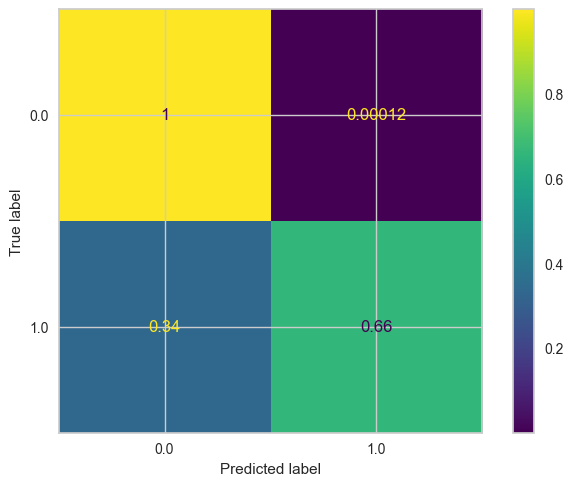

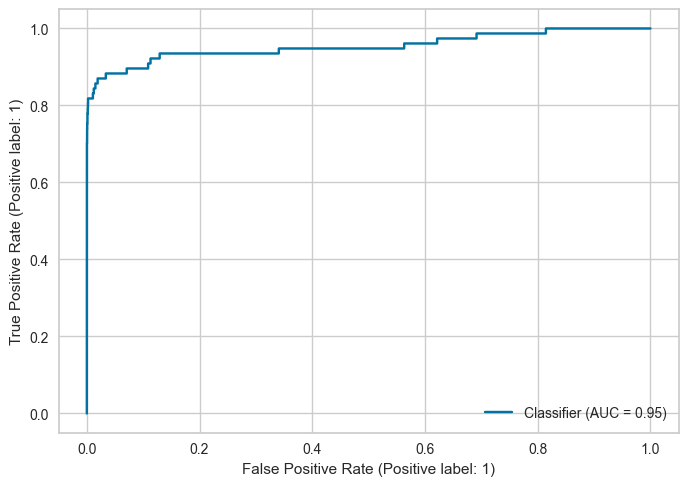

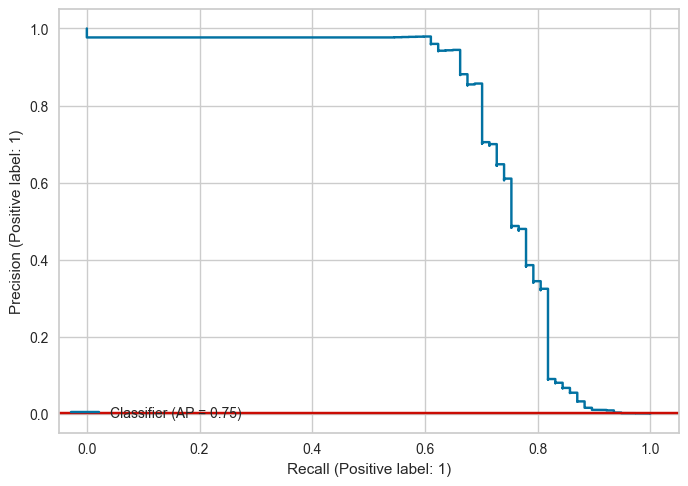

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      0.66      1.00      0.81      0.68     59855
        1.0       0.88      0.66      1.00      0.76      0.81      0.64        77

avg / total       1.00      1.00      0.66      1.00      0.81      0.68     59932

AUPRC: 0.7510390929975392
AP: 0.745047413344744


In [937]:
lstm.evaluate(test_df)